# Two-dimensional Taylor Green Vortex

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/physics_driven/mindspore_taylor_green2D.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/physics_driven/mindspore_taylor_green2D.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_en/physics_driven/taylor_green2D.ipynb)

This notebook requires **MindSpore version >= 2.0.0** to support new APIs including: *mindspore.jit, mindspore.jit_class, mindspore.jacrev*.

## Overview

In fluid dynamics, the Taylor-Green vortex is an unsteady flow of a decaying vortex, which has an exact closed form solution of the incompressible Navier-Stokes equations in Cartesian coordinates.

Physics-informed Neural Networks (PINNs) provides a new method for quickly solving complex fluid problems by using loss functions that approximate governing equations coupled with simple network configurations. In this case, the data-driven characteristic of neural network is used along with `PINNs` to solve the 2D taylor green vortex problem

## Two-dimensional Incompressible Navier-Stokes Equation

The Navier-Stokes equation, referred to as `N-S` equation, is a classical partial differential equation in the field of fluid mechanics. In the case of viscous incompressibility, the dimensionless `N-S` equation has the following form:

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

$$
\frac{\partial u} {\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = - \frac{\partial p}{\partial x} + \frac{1} {Re} (\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2})
$$

$$
\frac{\partial v} {\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = - \frac{\partial p}{\partial y} + \frac{1} {Re} (\frac{\partial^2v}{\partial x^2} + \frac{\partial^2v}{\partial y^2})
$$

where `Re` stands for Reynolds number.

In this case, the PINNs method is used to learn the mapping from the location and time to flow field quantities to solve the `N-S` equation.

$$
(x, y, t) \mapsto (u, v, p)
$$

## Technology Path

The specific process of MindSpore Flow for solving the problem is as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Optimizer.
4. NavierStokes2D.
5. Model Training.
6. Model Evaluation and Visualization.

## Importing Necessary Package

In [1]:
import time
import numpy as np
import sympy
import mindspore
from mindspore import nn, ops, jit, set_seed
from mindspore import numpy as mnp

The following `src` pacakage can be downloaded in [applications/physics_driven/navier_stokes/taylor_green/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/physics_driven/navier_stokes/taylor_green/src).

In [1]:
from mindflow.cell import MultiScaleFCCell
from mindflow.utils import load_yaml_config
from mindflow.pde import NavierStokes, sympy_to_mindspore

from src import create_training_dataset, create_test_dataset, calculate_l2_error, NavierStokes2D

set_seed(123456)
np.random.seed(123456)

The following `taylor_green_2D.yaml` can be downloaded in [applications/physics_driven/navier_stokes/taylor_green/configs/taylor_green_2D.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/applications/physics_driven/navier_stokes/taylor_green/configs/taylor_green_2D.yaml).

In [2]:
mindspore.set_context(mode=mindspore.GRAPH_MODE, device_target="GPU", device_id=0, save_graphs=False)
use_ascend = mindspore.get_context(attr_key='device_target') == "Ascend"

config = load_yaml_config('taylor_green_2D.yaml')

## Dataset Construction

Training dataset is imported through function _create_train_dataset_, contains domain points, initial condition points and boundary condition point. All datasets are sampled by APIs from mindflow.geometry.

Test dataset is imported through function create_test_dataset. In this case, the exact solution used to construct test dataset is given by [J Kim, P Moin, Application of a fractional-step method to incompressible Navier-Stokes equations, Journal of Computational Physics, Volume 59, Issue 2, 1985](https://www.ljll.math.upmc.fr/~frey/papers/Navier-Stokes/KimJ.,%20Application%20of%20a%20fractional%20step%20method%20to%20incompressible%20Navier-Stokes%20equations.pdf).

This example considers the aylor-Green eddy current sumulation of a square region of size $2\pi \times 2\pi$ at the $t \in (0,2)$ time slot. The exact solution to the problem is:

$$
u(x,y,t) = -cos(x)sin(y)e^{-2t}
$$

$$
v(x,y,t) = sin(x)cos(y)e^{-2t}
$$

$$
p(x,y,t) = -0.25(cos(2x)+cos(2y))e^{-4t}
$$



In [2]:
# create training dataset
taylor_dataset = create_training_dataset(config)
train_dataset = taylor_dataset.create_dataset(batch_size=config["train_batch_size"],
                                              shuffle=True,
                                              prebatched_data=True,
                                              drop_remainder=True)

# create test dataset
inputs, label = create_test_dataset(config)

## Model Construction

This example uses a simple fully-connected network with a depth of 6 layers and the activation function is the `tanh` function.

In [3]:
coord_min = np.array(config["geometry"]["coord_min"] + [config["geometry"]["time_min"]]).astype(np.float32)
coord_max = np.array(config["geometry"]["coord_max"] + [config["geometry"]["time_max"]]).astype(np.float32)
input_center = list(0.5 * (coord_max + coord_min))
input_scale = list(2.0 / (coord_max - coord_min))

model = MultiScaleFCCell(in_channels=config["model"]["in_channels"],
                         out_channels=config["model"]["out_channels"],
                         layers=config["model"]["layers"],
                         neurons=config["model"]["neurons"],
                         residual=config["model"]["residual"],
                         act='tanh',
                         num_scales=1,
                         input_scale=input_scale,
                         input_center=input_center)

## Optimizer

In [4]:
params = model.trainable_params()
optimizer = nn.Adam(params, learning_rate=config["optimizer"]["initial_lr"])

## NavierStokes2D

The following `NavierStokes2D` defines the navier-stokes' problem. Specifically, it includes 3 parts: governing equation, initial condition and boundary conditions. Initial condition and boundary conditions are constructed by the exact solution mentioned before.

In [5]:
class NavierStokes2D(NavierStokes):
    def __init__(self, model, re=100, loss_fn=nn.MSELoss()):
        super(NavierStokes2D, self).__init__(model, re=re, loss_fn=loss_fn)
        self.ic_nodes = sympy_to_mindspore(self.ic(), self.in_vars, self.out_vars)
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)

    def ic(self):
        """
        Define initial condition equations based on sympy, abstract method.
        """
        ic_u = self.u + sympy.cos(self.x) * sympy.sin(self.y)
        ic_v = self.v - sympy.sin(self.x) * sympy.cos(self.y)
        ic_p = self.p + 0.25 * (sympy.cos(2*self.x) + sympy.cos(2*self.y))
        equations = {"ic_u": ic_u, "ic_v": ic_v, "ic_p": ic_p}
        return equations

    def bc(self):
        """
        Define boundary condition equations based on sympy, abstract method.
        """
        bc_u = self.u + sympy.cos(self.x) * sympy.sin(self.y) * sympy.exp(-2*self.t)
        bc_v = self.v - sympy.sin(self.x) * sympy.cos(self.y) * sympy.exp(-2*self.t)
        bc_p = self.p + 0.25 * (sympy.cos(2*self.x) + sympy.cos(2*self.y)) * sympy.exp(-4*self.t)
        equations = {"bc_u": bc_u, "bc_v": bc_v, "bc_p": bc_p}
        return equations

    def get_loss(self, pde_data, ic_data, bc_data):
        """
        Compute loss of 3 parts: governing equation, initial condition and boundary conditions.

        Args:
            pde_data (Tensor): the input data of governing equations.
            ic_data (Tensor): the input data of initial condition.
            bc_data (Tensor): the input data of boundary condition.
        """
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_residual = ops.Concat(1)(pde_res)
        pde_loss = self.loss_fn(pde_residual, mnp.zeros_like(pde_residual))

        ic_res = self.parse_node(self.ic_nodes, inputs=ic_data)
        ic_residual = ops.Concat(1)(ic_res)
        ic_loss = self.loss_fn(ic_residual, mnp.zeros_like(ic_residual))

        bc_res = self.parse_node(self.bc_nodes, inputs=bc_data)
        bc_residual = ops.Concat(1)(bc_res)
        bc_loss = self.loss_fn(bc_residual, mnp.zeros_like(bc_residual))

        return pde_loss + ic_loss + bc_loss

## Model Training

With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks.

In [6]:
def train():
    problem = NavierStokes2D(model, re=config["Re"])

    if use_ascend:
        from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
        loss_scaler = DynamicLossScaler(1024, 2, 100)
        auto_mixed_precision(model, 'O3')

    def forward_fn(pde_data, ic_data, bc_data):
        loss = problem.get_loss(pde_data, ic_data, bc_data)
        if use_ascend:
            loss = loss_scaler.scale(loss)
        return loss

    grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(pde_data, ic_data, bc_data):
        loss, grads = grad_fn(pde_data, ic_data, bc_data)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            if all_finite(grads):
                grads = loss_scaler.unscale(grads)
                loss = ops.depend(loss, optimizer(grads))
        else:
            loss = ops.depend(loss, optimizer(grads))
        return loss

    epochs = config["train_epochs"]
    steps_per_epochs = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)
    for epoch in range(1, 1 + epochs):
        # train
        time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs):
            step_train_loss = sink_process()
        model.set_train(False)

        if epoch % config["eval_interval_epochs"] == 0:
            print(f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg) * 1000 :.3f} ms")
            calculate_l2_error(model, inputs, label, config)

In [7]:
start_time = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - start_time))

momentum_x: u(x, y, t)*Derivative(u(x, y, t), x) + v(x, y, t)*Derivative(u(x, y, t), y) + Derivative(p(x, y, t), x) + Derivative(u(x, y, t), t) - 1.0*Derivative(u(x, y, t), (x, 2)) - 1.0*Derivative(u(x, y, t), (y, 2))
    Item numbers of current derivative formula nodes: 6
momentum_y: u(x, y, t)*Derivative(v(x, y, t), x) + v(x, y, t)*Derivative(v(x, y, t), y) + Derivative(p(x, y, t), y) + Derivative(v(x, y, t), t) - 1.0*Derivative(v(x, y, t), (x, 2)) - 1.0*Derivative(v(x, y, t), (y, 2))
    Item numbers of current derivative formula nodes: 6
continuty: Derivative(u(x, y, t), x) + Derivative(v(x, y, t), y)
    Item numbers of current derivative formula nodes: 2
ic_u: u(x, y, t) + sin(y)*cos(x)
    Item numbers of current derivative formula nodes: 2
ic_v: v(x, y, t) - sin(x)*cos(y)
    Item numbers of current derivative formula nodes: 2
ic_p: p(x, y, t) + 0.25*cos(2*x) + 0.25*cos(2*y)
    Item numbers of current derivative formula nodes: 3
bc_u: u(x, y, t) + exp(-2*t)*sin(y)*cos(x)
    I

## Model Evaluation and Visualization

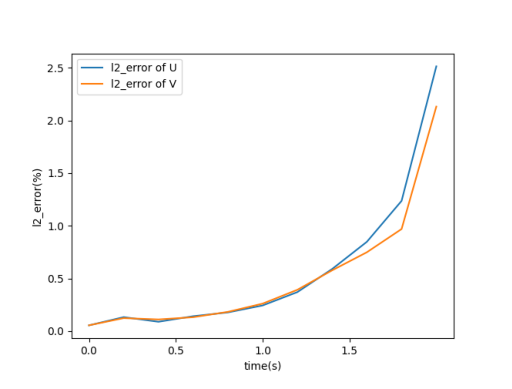

In [5]:
from src import visual

# visualization
visual(model=model, epoch=config["train_epochs"], input_data=inputs, label=label)

As the speed tends to decrease exponentially, the error becomes larger with time, but the overall is within the 5% error range.